In [442]:
import pandas as pd, numpy as np
np.set_printoptions(suppress=True)# 关掉科学计数法
import glob
import os
import csv
# 一次性merge多个pct_chg
from functools import reduce
from datetime import datetime, timedelta

# import yfinance as yf
import tushare as ts
import time, urllib
ts.set_token('2f31c3932ead9fcc3830879132cc3ec8df3566550f711889d4a30f67')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)

from plotly.graph_objs import Scatter,Layout
import plotly
import plotly.offline as py
import numpy as np
import plotly.graph_objs as go

#setting offilne
plotly.offline.init_notebook_mode(connected=True)

1. Download ETFs' most recent data
2. Use market cap to filter out the largest ETFs by market cap
3. Use correlation to filter out the most uncorrelated ETFs
4. Generate selected 40 tickers as pool
5. Calculate the positions' weights

# Parameters and Settings

In [443]:
# Mannually check our current position holdings for potential exit signals:
cur_positions = [
    '159916',
    '159918',
    '159932',
    '159933',
#     '159938',
    '159951',
    '510090',
    '510110',
    '510270',
    '510580',
    '511030',
#     '512010',
#     '512290',
#     '512560'
]
len(cur_positions)

10

In [444]:
date = [
    "2020-01-02",
    "2020-01-03",
    "2020-01-06",
    "2020-01-07",
    "2020-01-08",
    "2020-01-09",
    "2020-01-10",
    "2020-01-13",
    "2020-01-14",
    "2020-01-15",
    "2020-01-16",
    "2020-01-17",
    "2020-01-20",
    "2020-01-21",
    "2020-01-22",
    "2020-01-23",
    "2020-02-03",
    "2020-02-04",
    "2020-02-05",
    "2020-02-06",
    "2020-02-07",
    "2020-02-10",
    "2020-02-11",
    "2020-02-12",
    "2020-02-13",
    "2020-02-14",
    "2020-02-17",
    "2020-02-18",
    "2020-02-19",
    "2020-02-20",
    "2020-02-21",
    "2020-02-24",
    "2020-02-25",
    "2020-02-26",
    "2020-02-27"
]
sbtv1 = [0+1,#1/2
        0+1,
        0+1,
        0+1,
        -0.005/100+1,
        -0.001/100+1,
        0.01/100+1,
        0.01/100+1,
        0.03/100+1,
        0.02/100+1,
        -0.03/100+1,
        0.06/100+1,
        0.07/100+1,
        0.13/100+1,
        0.0795/100+1,
        0.2/100+1,
        0.68136/100+1,
         710/200000+1,#2/4
         824.42/200000+1,#2/5
         654.42/200000+1,#2/6
         745.42/200000+1,#2/7
         833/200000+1,#2/8
         933/200000+1,#2/11
         911/200000+1,
         676.53/200000+1,
         882.52/200000+1,
         1813.76/200000+1,
         2210.96/200000+1,
         1947.66/200000+1,
         2553.70/200000+1,
         2881.31/200000+1, #2020-02-21
         3423.72/200000+1,
         3239.46/200000+1,
         2397.44/200000+1,
         2379.78/200000+1
        ]

# General Import of ETF Data

In [445]:
def handle_data_files_return_tickers(file_path):
    ch_etfs_df = pd.read_csv(file_path, engine="python")
    ch_etfs_df.dropna(inplace = True)
    ch_etfs_df['基金规模\n[单位] 元'] = ch_etfs_df['基金规模\n[单位] 元'].apply(lambda x: float(x.replace(",","")))
    ch_etfs_df['机构投资者持有份额\n[报告期] 2019中报\n[单位] 份'] = ch_etfs_df['机构投资者持有份额\n[报告期] 2019中报\n[单位] 份'].apply(lambda x: float(x.replace(",","")))
    ch_etfs_df.sort_values("基金规模\n[单位] 元", ascending=False, inplace =True)
    ch_etfs_df = ch_etfs_df
    ch_etfs = ch_etfs_df.copy()
    ch_etfs['code'] =ch_etfs['证券代码'].apply(lambda x: str(x)[:6])
    ch_etfs_ticker = list(ch_etfs['code'].unique())
    return ch_etfs_ticker

def select_df_from_db_by_tickers(path, ticker_list):
    # e.g. ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
    csv_path = path+"*.csv"
    files = glob.glob(csv_path)
    
    tickers_data = []
    if len(ticker_list)!=1:
        for ticker in ticker_list:
            print("Reading: ", ticker)
            df = pd.read_csv(path+ticker+".csv")
            tickers_data.append(df)
        tickers_data_concated = pd.concat(tickers_data)
        tickers_data_concated.reset_index(inplace=True)
        del tickers_data_concated['index']
    else:
        df = pd.read_csv(path+ticker_list[0]+".csv")
        tickers_data_concated = df
    return tickers_data_concated

def get_df_date_price_code(path, ticker_list, date_col, price_col, code_col):
    # for etf data cols are 'date', 'close', 'code'
    ticker_df_list = []
    for ticker in ticker_list:
        print("Reading Assets: ", ticker)
        try:
            ticker_df = pd.read_csv(path+ticker+".csv")
            ticker_df = ticker_df.sort_values(date_col)
            ticker_df = ticker_df[[date_col, price_col, code_col]]
            ticker_df['pct_chg'] = ticker_df[price_col].pct_change()
            ticker_df = ticker_df[[date_col, 'close']].dropna()
#             ticker_df.columns = [date_col,ticker]
#             ticker_df[date_col] = pd.to_datetime(ticker_df[date_col])
            ticker_df['code'] = ticker
            ticker_df_list.append(ticker_df)
#             tickers_data_concated.reset_index(inplace=True)
#             del tickers_data_concated['index']
        except:
            pass
    tickers_data_concated = pd.concat(ticker_df_list)
    return tickers_data_concated

# 先为之后使用reduce铺路：创造一个merge的函数，这里的目的是为了将多资产数据基于date_col进行merge：
def merge_df(df1, df2, date_col="date"):
    # By default the etf's date_col goes by 'date'
    merged = df1.merge(df2, on = date_col, how = 'outer')
    merged.sort_values(date_col, inplace = True)
    return merged

In [446]:
etf_ticker_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_ETFs.csv"
etf_path_to_csv = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
ch_etfs_tickers = handle_data_files_return_tickers(etf_ticker_path)
tickers_data_concated = select_df_from_db_by_tickers(etf_path_to_csv, ch_etfs_tickers)

Reading:  510500
Reading:  510050
Reading:  510300
Reading:  510330
Reading:  159919
Reading:  510180
Reading:  159915
Reading:  512960
Reading:  512950
Reading:  510810
Reading:  512880
Reading:  510900
Reading:  518880
Reading:  510310
Reading:  159901
Reading:  512500
Reading:  159920
Reading:  159949
Reading:  510230
Reading:  510850
Reading:  159959
Reading:  511030
Reading:  510390
Reading:  510510
Reading:  510380
Reading:  512000
Reading:  159962
Reading:  510360
Reading:  159928
Reading:  159922
Reading:  510880
Reading:  159938
Reading:  510590
Reading:  159902
Reading:  512660
Reading:  512070
Reading:  159939
Reading:  511220
Reading:  512900
Reading:  512380
Reading:  512800
Reading:  512580
Reading:  159905
Reading:  159952
Reading:  159910
Reading:  511270
Reading:  513050
Reading:  159948
Reading:  512980
Reading:  511020
Reading:  513500
Reading:  510580
Reading:  513660
Reading:  512330
Reading:  512010
Reading:  159916
Reading:  512160
Reading:  510560
Reading:  5125

In [447]:
tickers_data_concated.head()

,date,open,close,high,low,volume,code
0,2013-03-15,0.967,0.970,0.985,0.955,3259273.0,510500
1,2013-03-18,0.955,0.954,0.972,0.953,936962.0,510500
2,2013-03-19,0.956,0.960,0.960,0.941,1080499.0,510500
3,2013-03-20,0.960,0.985,0.986,0.958,501195.0,510500
4,2013-03-21,0.985,0.995,0.996,0.981,698243.0,510500


# Use Volume to Rank

Every year we will need to check using this function. The most recent time of update is 20200221

In [448]:
def vol_ewm(vol_series, window_span):
    vol_mean = vol_series.ewm(span = window_span).mean()
    return vol_mean

def add_vol_ewm_col(df, code_col, vol_col, window_span):
    vol_col_rename = str(window_span)+"_vol_ewm"
    df[vol_col_rename] = df.groupby([code_col])[vol_col].apply(lambda x: vol_ewm(x, window_span))
    return df

def rank_by_vol_ewm(df, date_col, window_span, rank_num, ascending_default = False):
    vol_col_rename = "{}_vol_ewm".format(window_span)
    df['vol_ewm_rank'] = df.groupby([date_col])[vol_col_rename].apply(lambda x: x.rank(ascending = ascending_default))
    vol_rank_condition = df['vol_ewm_rank']<=rank_num
    vol_filtered_df = df[(df[date_col]==df[date_col].values[-1])&(vol_rank_condition)]
    vol_filtered_df.sort_values("vol_ewm_rank", ascending=True, inplace=True)
    return vol_filtered_df

def filtered_tickers(df, code_col):
    filtered_tickers = list(df[code_col].unique().astype(str))
    return filtered_tickers

In [449]:
vol_added_df = add_vol_ewm_col(tickers_data_concated,'code','volume',252)
vol_filtered_df = rank_by_vol_ewm(vol_added_df, 'date', 252, 50, ascending_default = False)
vol_filtered_tickers = filtered_tickers(vol_filtered_df, 'code')

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [450]:
len(vol_filtered_tickers)

50

# Calculate Correlations as Filters

In [451]:
def merge_df_for_corr(ticker_df_list, date_col):
    # Here below merge_df is a function instead of a variable
    
    merged_all = reduce(merge_df, ticker_df_list)
    # For etf data the date col is 'date'
    merged_all.set_index(date_col, inplace=True)
    merged_all.dropna(how="all", axis = 1, inplace = True)
    return merged_all

def get_df_date_price_code_returns(path, ticker_list, date_col, price_col, code_col):
    # for etf data cols are 'date', 'close', 'code'
    ticker_df_list = []
    for ticker in ticker_list:
        print("Reading Assets: ", ticker)
        try:
            ticker_df = pd.read_csv(path+ticker+".csv")
            ticker_df = ticker_df.sort_values(date_col)
            ticker_df = ticker_df[[date_col, price_col, code_col]]
            ticker_df['pct_chg'] = ticker_df[price_col].pct_change()
            ticker_df['cum_returns'] = ticker_df['pct_chg'].cumsum()
            ticker_df = ticker_df[[date_col, 'pct_chg']].dropna()
            ticker_df.columns = [date_col,ticker]
            ticker_df[date_col] = pd.to_datetime(ticker_df[date_col])
            ticker_df_list.append(ticker_df)
        except:
            pass
    return ticker_df_list

def get_df_date_price_code_cumreturns(path, ticker_list, date_col, price_col, code_col):
    # for etf data cols are 'date', 'close', 'code'
    ticker_df_list = []
    for ticker in ticker_list:
        print("Reading Assets: ", ticker)
        try:
            ticker_df = pd.read_csv(path+ticker+".csv")
            ticker_df = ticker_df.sort_values(date_col)
            ticker_df = ticker_df[[date_col, price_col, code_col]]
            ticker_df['pct_chg'] = ticker_df[price_col].pct_change()
            ticker_df['cum_returns'] = ticker_df['pct_chg'].cumsum()
            ticker_df = ticker_df[[date_col, 'cum_returns']].dropna()
            ticker_df.columns = [date_col,ticker]
            ticker_df[date_col] = pd.to_datetime(ticker_df[date_col])
            ticker_df_list.append(ticker_df)
        except:
            pass
    return ticker_df_list

In [452]:
df_returns = get_df_date_price_code_returns(etf_path_to_csv, vol_filtered_tickers, 'date', 'close', 'code')
df_cum_returns = get_df_date_price_code_cumreturns(etf_path_to_csv, vol_filtered_tickers, 'date', 'close', 'code')
merged_returns = merge_df_for_corr(df_returns, "date")
merged_cumreturns = merge_df_for_corr(df_cum_returns, "date")

Reading Assets:  512880
Reading Assets:  510900
Reading Assets:  159949
Reading Assets:  510050
Reading Assets:  159915
Reading Assets:  159920
Reading Assets:  512000
Reading Assets:  510300
Reading Assets:  518880
Reading Assets:  510500
Reading Assets:  512660
Reading Assets:  510330
Reading Assets:  512800
Reading Assets:  159919
Reading Assets:  512500
Reading Assets:  512380
Reading Assets:  510850
Reading Assets:  512290
Reading Assets:  512960
Reading Assets:  512280
Reading Assets:  159939
Reading Assets:  510310
Reading Assets:  512090
Reading Assets:  159952
Reading Assets:  513500
Reading Assets:  513050
Reading Assets:  512010
Reading Assets:  512160
Reading Assets:  512980
Reading Assets:  512400
Reading Assets:  159901
Reading Assets:  510510
Reading Assets:  512690
Reading Assets:  512180
Reading Assets:  513100
Reading Assets:  512950
Reading Assets:  512900
Reading Assets:  512100
Reading Assets:  510180
Reading Assets:  159905
Reading Assets:  159922
Reading Assets: 

## Plot assets and correlation matrixs

In [453]:
# merged_cumreturns.plot(figsize = (25, 20))
# plt.title("Cumulative Returns on 50 ETFs", fontsize = 15)

In [454]:
# fig = plt.figure(figsize = (35, 25))
# ax = fig.add_subplot(111)
# ax = sns.heatmap(merged_returns.corr(),\
#                 annot=True, annot_kws={'size':12, 'weight': 'bold'}, cmap = 'Blues')
# plt.title("Correlation Heatmap on 50 ETFs' Returns", fontsize = 20);

# Filter the top 40 ETFs by Lowest Correlations

In [455]:
def select_N_lowest_corr_assets(merged_all, asset_category, n):
    # asset_category be default for etf is 'etf'
    # Create ETFs' correlation matrix dataframe
    merged_all_corr = merged_all.corr()
    merged_all_corr_abs = abs(merged_all_corr)
    corr_mean_dict = {}
    for row in merged_all_corr_abs.iterrows():
        row_list = list(row)
        print(row_list[0])
        print(np.mean(row_list[1]))
        corr_mean_dict[row_list[0]] = np.mean(row_list[1])
        print("========")
    corr_mean_df = pd.DataFrame()
    corr_mean_df[asset_category] = corr_mean_dict.keys()
    corr_mean_df['abs_corr_mean'] = corr_mean_dict.values()
    corr_mean_df_assets = corr_mean_df.sort_values("abs_corr_mean", ascending=True)
    lowest_corr_assets_list = list(corr_mean_df_assets[asset_category])[:n]
    return lowest_corr_assets_list, corr_mean_df_assets

def MACD(df, n_fast, n_slow, n_macd, price_col): # n_fast = 12, n_slow = 26
    """
    http://stockcharts.com/docs/doku.php?id=scans:indicators
    MACD, MACD Signal and MACD difference, rationale CHECKED, code CHECKED, updated
    # Conventional look-back window for calculating MACDsign is 9
    """
    EMAfast = df[price_col].ewm(span = n_fast, min_periods = n_fast - 1).mean()
    EMAslow = df[price_col].ewm(span = n_slow, min_periods = n_slow - 1).mean()
    MACD = pd.Series(EMAfast - EMAslow, name = 'MACD_' + str(n_fast) + '_' + str(n_slow))
    MACDsign = MACD.ewm(span = n_macd, min_periods = n_macd-1).mean().rename('MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name = 'MACDdiff_' + str(n_fast) + '_' + str(n_slow))
    df['MACD_Diff'] = MACD
    df['MACD_Diff_EMA'] = MACDsign
    df['MACD'] = MACDdiff
    df['SIGNAL_STATUS'] = df['MACD'].apply(lambda x: "多头状态" if x>0 else ("空头状态" if x<0 else "无信号状态"))
    return df

def calc_macd_signals(tickers_data_concated, ticker_list, code_col, ticker_type, price_col):
    signal_record = []
    signal_data = []
    if len(ticker_list)!=1:
        for ticker in ticker_list:
            print("Calculating Signal for: ", ticker)
            try:
                if ticker_type == "float":
                # Be aware of types of ticker values here, whether it's float or strings, depends.
                    single_ticker_df = tickers_data_concated[tickers_data_concated[code_col]==float(ticker)]
                elif ticker_type == "string":
                    single_ticker_df = tickers_data_concated[tickers_data_concated[code_col]==ticker]
                signal_df = MACD(single_ticker_df, 12, 26, 9, price_col)
#                 last_signal = signal_df[[code_col,'SIGNAL_STATUS']].values[-1]
                signal_data.append(signal_df)
#                 signal_record.append(last_signal)
            except:
                pass
        signal_data_df = pd.concat(signal_data)
    else:
        print("Calculating Signal for: ", ticker_list[0])
        try:                
            print("getting thru")
            signal_df = MACD(tickers_data_concated, 12, 26, 9, price_col)
#             last_signal = signal_df[[code_col,'SIGNAL_STATUS']].values[-1]
#             signal_data.append(signal_df)
#             signal_record.append(last_signal)
        except:
            pass
        signal_data_df = signal_df
    return signal_data_df
    
def make_numeric_signals(series):
    for item in series:
#         print(item)
        if item =="多":
            return 1
        elif item =="空":
            return -1
        else:
            return 0
        
def generate_most_recent_signal_data_v1(signal_data_df, date_col, code_col):
    # v1 is the version of generating the og macd signals
    signal_data_df['SIGNAL_DIRECTION'] = signal_data_df['SIGNAL_STATUS'].apply(lambda x: make_numeric_signals(x))
    signal_data_df['SIGNAL_DIRECTION_DIFF'] = signal_data_df.groupby([code_col])['SIGNAL_DIRECTION'].diff()
    signal_data_df['SIGNAL_ACTION'] = signal_data_df['SIGNAL_DIRECTION_DIFF'].apply(lambda x: "LONG" if x==2 else("SHORT" if x==-2 else "NO CHANGE"))
    most_recent_signals = signal_data_df.groupby([code_col])[[date_col,code_col,'SIGNAL_STATUS','SIGNAL_ACTION']].tail(1)
    return most_recent_signals

def check_macd_signal_plot(signal_data_df, ticker, cols_list_to_plot, code_col, N_tails, date_col):
    signal_data_df_copy = signal_data_df.copy()
    signal_data_df_copy.set_index(date_col, inplace = True)
    df_to_plot = signal_data_df_copy[signal_data_df_copy[code_col]==ticker][cols_list_to_plot].tail(N_tails)
    df_to_plot.plot(figsize = (18, 6))
    plt.title("{}".format(ticker))
    
lowest_corr_etf_list,corr_mean_df_assets = select_N_lowest_corr_assets(merged_returns, "etf", 40)
# Calculate MACD
# P.S. MACD is calculated based on the following df structure: date, open, high, low, close
lowest_corr_etf_df = select_df_from_db_by_tickers(etf_path_to_csv, lowest_corr_etf_list)
lowest_corr_etf_macd_signals = calc_macd_signals(lowest_corr_etf_df, lowest_corr_etf_list, 'code', 'float','close')
most_recent_etf_macd_signals = generate_most_recent_signal_data_v1(lowest_corr_etf_macd_signals, 'date','code')

512880
0.6879289740538637
510900
0.5429496739698686
159949
0.7261774052107585
510050
0.6594120574711368
159915
0.6693350272296945
159920
0.4990623653357623
512000
0.684641027303079
510300
0.7340395079869907
518880
0.1353967130666402
510500
0.5248200910856893
512660
0.6236749242070441
510330
0.7337946922681315
512800
0.629579957471203
159919
0.647465786000037
512500
0.7695534132556464
512380
0.8346967068807587
510850
0.7842163255468242
512290
0.5801988335349023
512960
0.8132199457461937
512280
0.8341450958087081
159939
0.6585823319609108
510310
0.7423945453442424
512090
0.8362649286178971
159952
0.7458962508965317
513500
0.2792126273863909
513050
0.5333608122662753
512010
0.5930794724481477
512160
0.8302173906869318
512980
0.7367515862785278
512400
0.6384560567252223
159901
0.5489787869349624
510510
0.7298210249879042
512690
0.6416945974336088
512180
0.8287327510413367
513100
0.3224212920369135
512950
0.8142726174492342
512900
0.6898536487831736
512100
0.72969806472638
510180
0.54011531

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Calculating Signal for:  512290
Calculating Signal for:  512010
Calculating Signal for:  159928
Calculating Signal for:  512660
Calculating Signal for:  512800
Calculating Signal for:  512400
Calculating Signal for:  512690
Calculating Signal for:  159919
Calculating Signal for:  159939
Calculating Signal for:  510050
Calculating Signal for:  159938
Calculating Signal for:  159915
Calculating Signal for:  159905
Calculating Signal for:  510880
Calculating Signal for:  512330
Calculating Signal for:  512000
Calculating Signal for:  512880
Calculating Signal for:  512900
Calculating Signal for:  159922
Calculating Signal for:  159902
Calculating Signal for:  510810
Calculating Signal for:  159949
Calculating Signal for:  512100
Calculating Signal for:  510510
Calculating Signal for:  510330
Calculating Signal for:  510300
Calculating Signal for:  512980
Calculating Signal for:  510310
Calculating Signal for:  159952
Calculating Signal for:  512500
Calculating Signal for:  512990


In [456]:
# This could be different from our current position holdings
most_recent_etf_macd_signals['TYPE'] = 'TARGET'
most_recent_etf_macd_signals

,date,code,SIGNAL_STATUS,SIGNAL_ACTION,TYPE
1603,2020-02-27,518880,多头状态,NO CHANGE,TARGET
3093,2020-02-27,513500,空头状态,NO CHANGE,TARGET
4747,2020-02-27,513100,空头状态,NO CHANGE,TARGET
6535,2020-02-27,159920,空头状态,NO CHANGE,TARGET
8225,2020-02-27,510500,多头状态,NO CHANGE,TARGET
8980,2020-02-27,513050,空头状态,NO CHANGE,TARGET
11444,2020-02-27,510180,多头状态,NO CHANGE,TARGET
13231,2020-02-27,510900,空头状态,NO CHANGE,TARGET
15695,2020-02-27,159901,多头状态,NO CHANGE,TARGET
15885,2020-02-27,512290,空头状态,NO CHANGE,TARGET


In [457]:
cur_pos_prices = select_df_from_db_by_tickers(etf_path_to_csv, cur_positions)
cur_pos_etf_macd_signals = calc_macd_signals(cur_pos_prices, cur_positions, 'code', 'float','close')
most_recent_cur_pos_etf_macd_signals = generate_most_recent_signal_data_v1(cur_pos_etf_macd_signals, 'date','code')
most_recent_cur_pos_etf_macd_signals['TYPE'] = 'CUR_POS'
signal_df = most_recent_cur_pos_etf_macd_signals.merge(most_recent_etf_macd_signals, on = ['date','code'], how = 'outer')

Reading:  159916
Reading:  159918
Reading:  159932
Reading:  159933
Reading:  159951
Reading:  510090
Reading:  510110
Reading:  510270
Reading:  510580
Reading:  511030
Calculating Signal for:  159916
Calculating Signal for:  159918
Calculating Signal for:  159932
Calculating Signal for:  159933
Calculating Signal for:  159951
Calculating Signal for:  510090
Calculating Signal for:  510110
Calculating Signal for:  510270
Calculating Signal for:  510580
Calculating Signal for:  511030


/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

# Risk Parity

In [458]:
from scipy.optimize import minimize

def get_smart_weight(pct, method='risk parity', cov_adjusted=False, wts_adjusted=False):
    if cov_adjusted == False:
        #协方差矩阵
        cov_mat = pct.cov()
    else:
        #调整后的半衰协方差矩阵
        cov_mat = pct.iloc[:len(pct)/4].cov()*(1/10.) + pct.iloc[len(pct)/4+1:len(pct)/2].cov()*(2/10.) +\
            pct.iloc[len(pct)/2+1:len(pct)/4*3].cov()*(3/10.) + pct.iloc[len(pct)/4*3+1:].cov()*(4/10.)
    if not isinstance(cov_mat, pd.DataFrame):
        raise ValueError('cov_mat should be pandas DataFrame！')
        
    omega = np.matrix(cov_mat.values)  # 协方差矩阵

    a, b = np.linalg.eig(np.array(cov_mat)) #a为特征值,b为特征向量
    a = np.matrix(a)
    b = np.matrix(b)
    # 定义目标函数
    
    def fun1(x):
        tmp = (omega * np.matrix(x).T).A1
        risk = x * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
        delta_risk = [sum((i - risk)**2) for i in risk]
        return sum(delta_risk)
    
    def fun2(x):
        tmp = (b**(-1) * omega * np.matrix(x).T).A1
        risk = (b**(-1)*np.matrix(x).T).A1 * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
        delta_risk = [sum((i - risk)**2) for i in risk]
        return sum(delta_risk)
    
    # 初始值 + 约束条件 
    x0 = np.ones(omega.shape[0]) / omega.shape[0]  
    bnds = tuple((0,None) for x in x0)
    cons = ({'type':'eq', 'fun': lambda x: sum(x) - 1})
    options={'disp':False, 'maxiter':1000, 'ftol':1e-20}
        
    if method == 'risk parity':
        res = minimize(fun1, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
    elif method == 'pc risk parity':
        res = minimize(fun2, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
    else:
        raise ValueError('method error！！！')
        
    # 权重调整
    if res['success'] == False:
        # print res['message']
        pass
    wts = pd.Series(index=cov_mat.index, data=res['x'])
    
    if wts_adjusted == True:
        wts[wts < 0.0001]=0.0
        wts = wts / wts.sum()
    elif wts_adjusted == False:
        wts = wts / wts.sum()
    else:
        raise ValueError('wts_adjusted should be True/False！')
        
    risk = pd.Series(wts * (omega * np.matrix(wts).T).A1 / np.sqrt(np.matrix(wts) * omega * np.matrix(wts).T).A1[0],index = cov_mat.index)
    risk[risk<0.0] = 0.0
    return wts,risk

In [459]:
wts, risk = get_smart_weight(merged_returns, method='risk parity', cov_adjusted=False, wts_adjusted=False)
df_wts = pd.DataFrame(wts)
df_wts.reset_index(inplace = True)
df_wts.columns = ['ETF', 'Portfolio_Weight']

In [460]:
# Top 40 ETF ranked by 252-day-vol_ewm on 20200221
# list(merged_returns.columns)

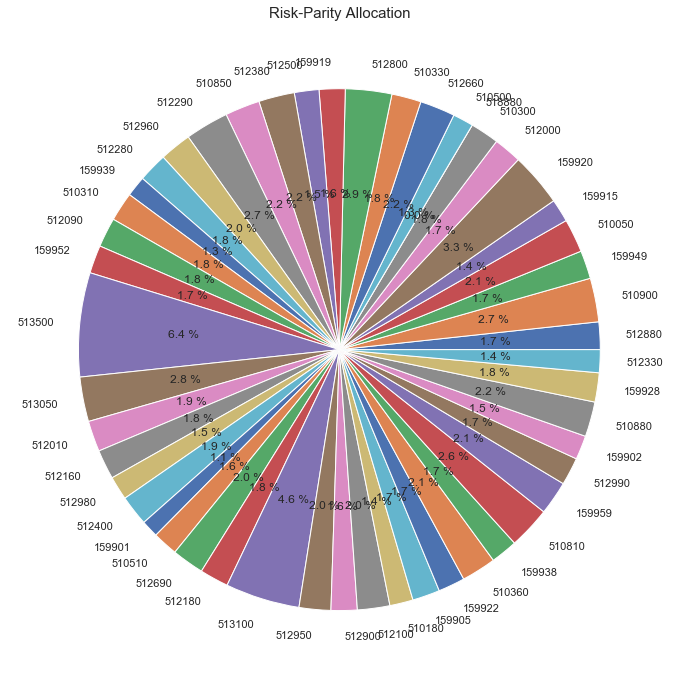

In [461]:
etfs = list(df_wts['ETF'])
weights = list(df_wts['Portfolio_Weight'])
# 保证圆形
plt.figure(1, figsize = (12, 12))
plt.axes(aspect=1)
plt.pie(x=weights, labels=etfs, autopct='%3.1f %%')
plt.title("Risk-Parity Allocation", fontsize = 15)
plt.show()

In [462]:
signal_df['code'] = signal_df['code'].astype(str)
signal_df['WEIGHT'] = ""

In [463]:
# match the weights of each ETF
for i, code_wts in enumerate(df_wts['ETF']):
    for j, code_signal in enumerate(signal_df['code']):
        if code_wts == code_signal:
            signal_df['WEIGHT'].values[j]=df_wts['Portfolio_Weight'].values[i]
            
# create the most recent trading date
last_date = signal_df['date'].values[0]

# get the close data for these tickers
signal_df_etfs = list(signal_df['code'].unique())
signal_df_closes = get_df_date_price_code(etf_path_to_csv, signal_df_etfs, 'date', 'close', 'code')

# filter the data by the most recent trading date
last_date_signal_df_closes = signal_df_closes[signal_df_closes['date']==last_date]

# merge with signal_df to get the closes so that target shares can be calculated later
signal_df_final = last_date_signal_df_closes.merge(signal_df, on = ['date','code'], how = 'outer')

# clean those without numbers in the WEIGHT columns
signal_df_final['WEIGHT'] = signal_df_final['WEIGHT'].apply(lambda x: 0 if x=="" else x)

# calculate target shares
account_values = 200000
signal_df_final['TARGET_SHARES'] = (signal_df_final['WEIGHT']*account_values)/signal_df_final['close']

# filter to get those with potential trading actions needed
condition_of_action = (signal_df_final['SIGNAL_ACTION_x']=="LONG")|(signal_df_final['SIGNAL_ACTION_x']=="SHORT")|\
                    (signal_df_final['SIGNAL_ACTION_y']=="LONG")|(signal_df_final['SIGNAL_ACTION_y']=="SHORT")
df_actions = signal_df_final[condition_of_action]

Reading Assets:  159916
Reading Assets:  159918
Reading Assets:  159932
Reading Assets:  159933
Reading Assets:  159951
Reading Assets:  510090
Reading Assets:  510110
Reading Assets:  510270
Reading Assets:  510580
Reading Assets:  511030
Reading Assets:  518880
Reading Assets:  513500
Reading Assets:  513100
Reading Assets:  159920
Reading Assets:  510500
Reading Assets:  513050
Reading Assets:  510180
Reading Assets:  510900
Reading Assets:  159901
Reading Assets:  512290
Reading Assets:  512010
Reading Assets:  159928
Reading Assets:  512660
Reading Assets:  512800
Reading Assets:  512400
Reading Assets:  512690
Reading Assets:  159919
Reading Assets:  159939
Reading Assets:  510050
Reading Assets:  159938
Reading Assets:  159915
Reading Assets:  159905
Reading Assets:  510880
Reading Assets:  512330
Reading Assets:  512000
Reading Assets:  512880
Reading Assets:  512900
Reading Assets:  159922
Reading Assets:  159902
Reading Assets:  510810
Reading Assets:  159949
Reading Assets: 

## [Save] signal_df and df_action data

In [464]:
signal_df_final.to_csv("signal_df_final.csv", mode='a', header=False)

In [465]:
df_actions.to_csv("df_actions.csv", mode='a', header=False)

In [466]:
df_actions

,date,close,code,SIGNAL_STATUS_x,SIGNAL_ACTION_x,TYPE_x,SIGNAL_STATUS_y,SIGNAL_ACTION_y,TYPE_y,WEIGHT,TARGET_SHARES


# Live Risk Monitor

## Position Concentration Risk - Correlation Monitor

In [467]:
cur_pos_returns = get_df_date_price_code_returns(etf_path_to_csv, cur_positions, 'date', 'close', 'code')
# cur_pos_cum_returns = get_df_date_price_code_cumreturns(etf_path_to_csv, cur_positions, 'date', 'close', 'code')
cur_pos_merged_returns = merge_df_for_corr(cur_pos_returns, "date")
# cur_pos_merged_cumreturns = merge_df_for_corr(cur_pos_merged_returns, "date")

# merged_cumreturns.plot(figsize = (25, 20))
# plt.title("Cumulative Returns on 50 ETFs", fontsize = 15)

Reading Assets:  159916
Reading Assets:  159918
Reading Assets:  159932
Reading Assets:  159933
Reading Assets:  159951
Reading Assets:  510090
Reading Assets:  510110
Reading Assets:  510270
Reading Assets:  510580
Reading Assets:  511030


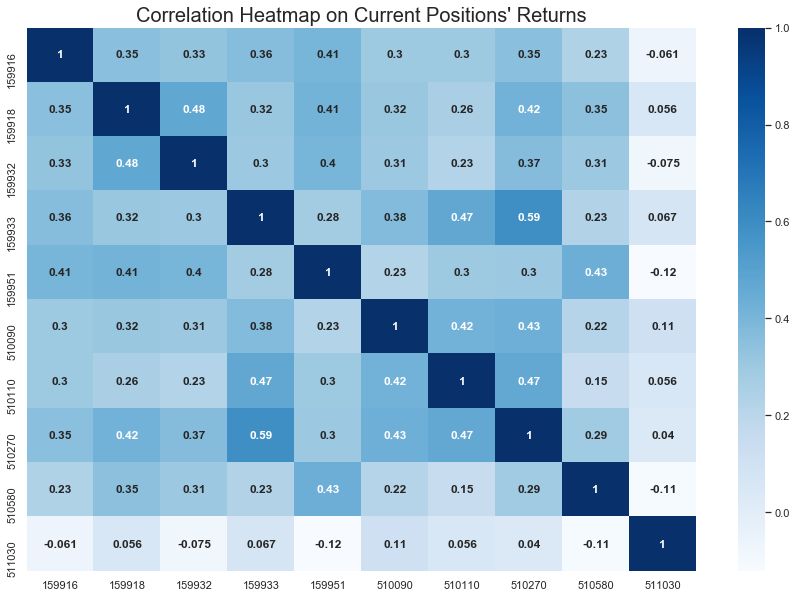

In [468]:
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)
ax = sns.heatmap(cur_pos_merged_returns.corr(),\
                annot=True, annot_kws={'size':12, 'weight': 'bold'}, cmap = 'Blues')
plt.title("Correlation Heatmap on Current Positions' Returns", fontsize = 20);

In [469]:
tgt_positions = list(signal_df[signal_df['TYPE_y']=="TARGET"]['code'])

In [470]:
# target_position-wise:
tgt_pos_returns = get_df_date_price_code_returns(etf_path_to_csv, tgt_positions, 'date', 'close', 'code')
# cur_pos_cum_returns = get_df_date_price_code_cumreturns(etf_path_to_csv, cur_positions, 'date', 'close', 'code')
tgt_pos_merged_returns = merge_df_for_corr(tgt_pos_returns, "date")

Reading Assets:  518880
Reading Assets:  513500
Reading Assets:  513100
Reading Assets:  159920
Reading Assets:  510500
Reading Assets:  513050
Reading Assets:  510180
Reading Assets:  510900
Reading Assets:  159901
Reading Assets:  512290
Reading Assets:  512010
Reading Assets:  159928
Reading Assets:  512660
Reading Assets:  512800
Reading Assets:  512400
Reading Assets:  512690
Reading Assets:  159919
Reading Assets:  159939
Reading Assets:  510050
Reading Assets:  159938
Reading Assets:  159915
Reading Assets:  159905
Reading Assets:  510880
Reading Assets:  512330
Reading Assets:  512000
Reading Assets:  512880
Reading Assets:  512900
Reading Assets:  159922
Reading Assets:  159902
Reading Assets:  510810
Reading Assets:  159949
Reading Assets:  512100
Reading Assets:  510510
Reading Assets:  510330
Reading Assets:  510300
Reading Assets:  512980
Reading Assets:  510310
Reading Assets:  159952
Reading Assets:  512500
Reading Assets:  512990


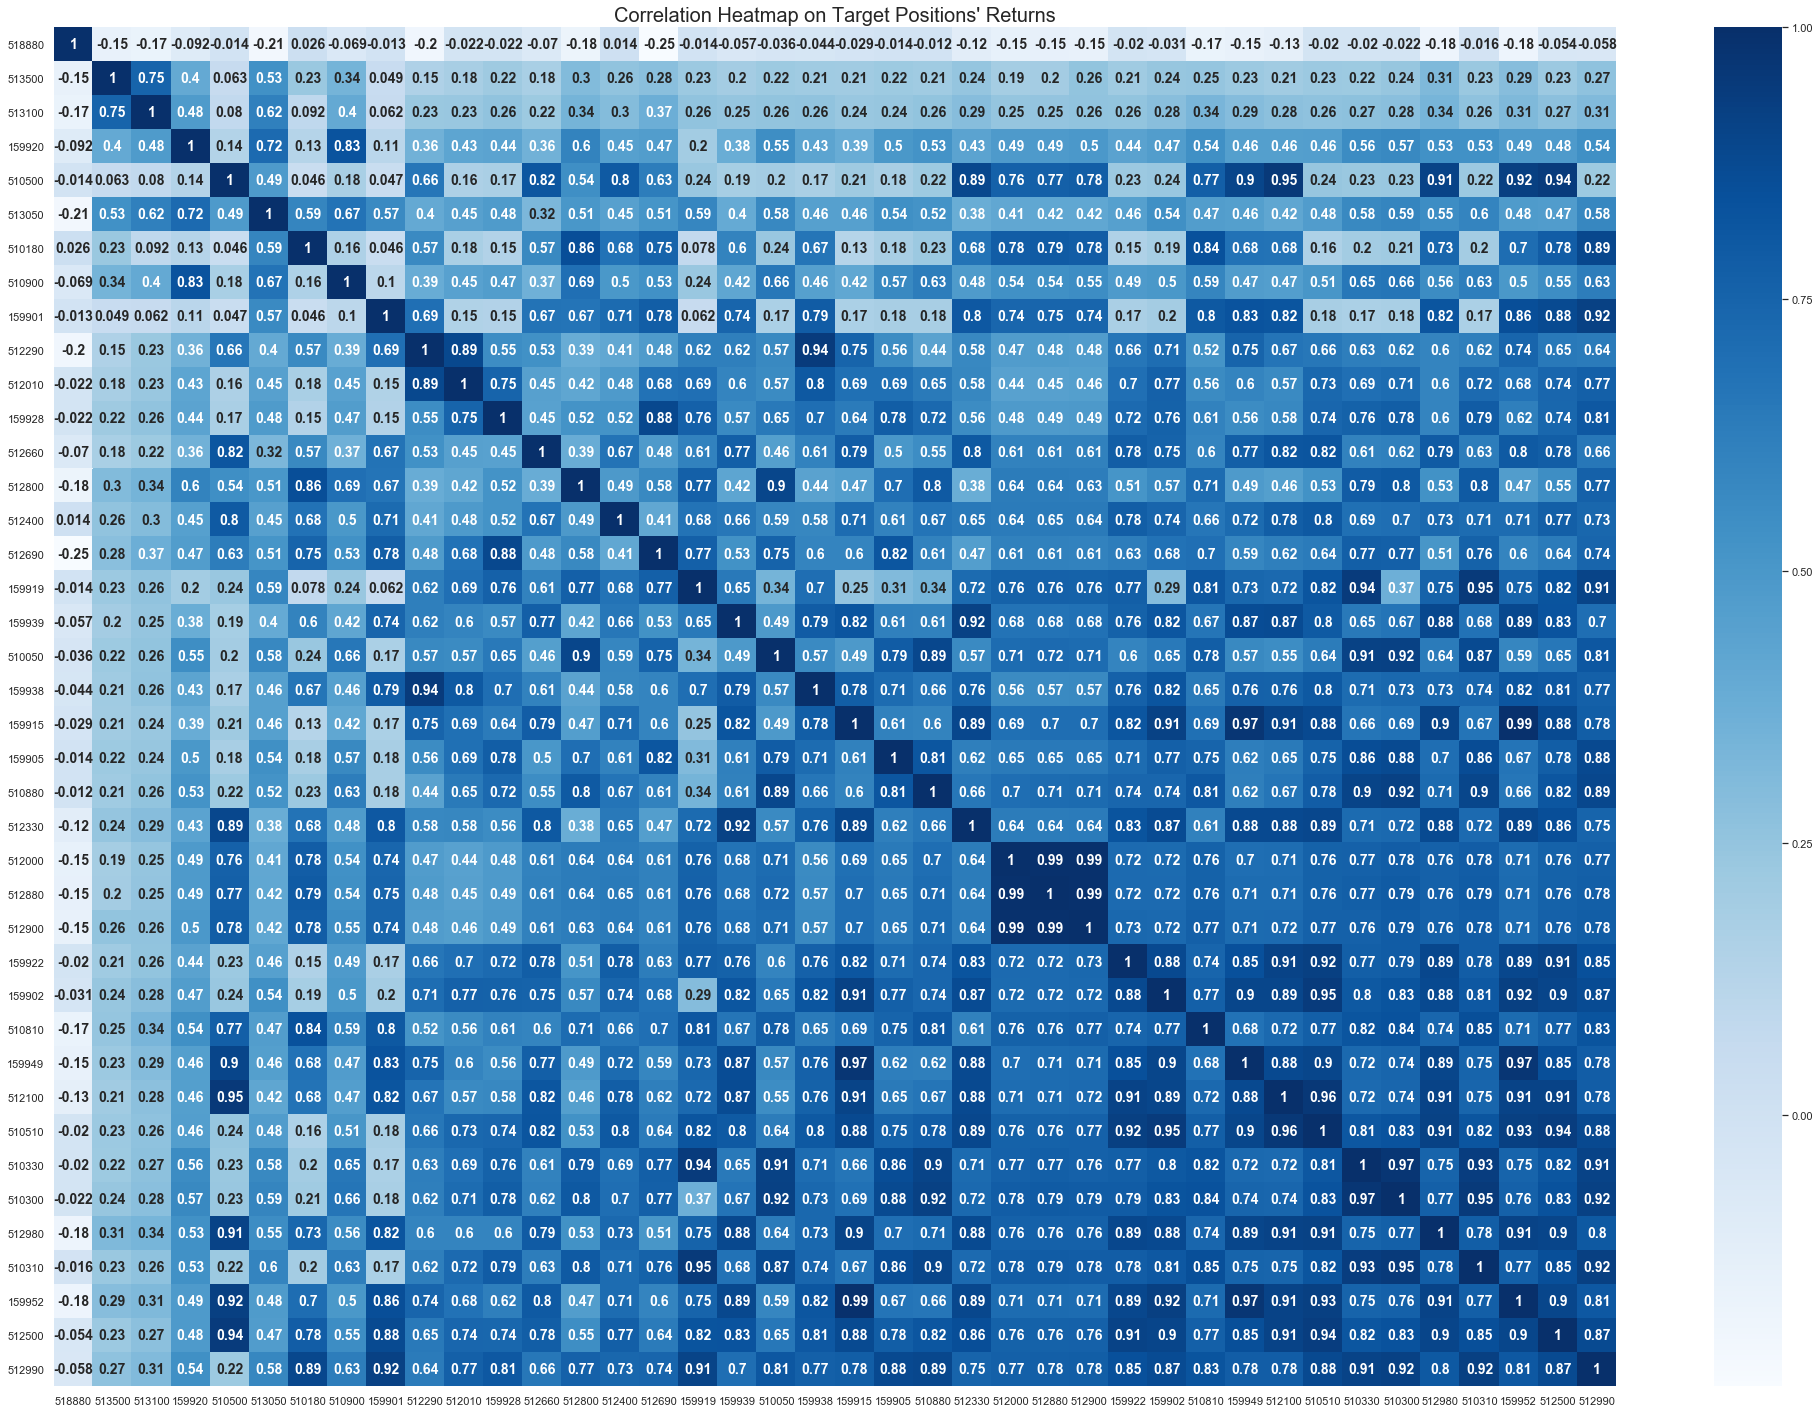

In [471]:
# corr heatmap of the target positions:
fig = plt.figure(figsize = (35, 25))
ax = fig.add_subplot(111)
ax = sns.heatmap(tgt_pos_merged_returns.corr(),\
                annot=True, annot_kws={'size':14, 'weight': 'bold'}, cmap = 'Blues')
plt.title("Correlation Heatmap on Target Positions' Returns", fontsize = 20);

In [472]:
signal_df

,date,code,SIGNAL_STATUS_x,SIGNAL_ACTION_x,TYPE_x,SIGNAL_STATUS_y,SIGNAL_ACTION_y,TYPE_y,WEIGHT
0,2020-02-27,159916,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
1,2020-02-27,159918,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
2,2020-02-27,159932,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
3,2020-02-27,159933,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
4,2020-02-27,159951,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
5,2020-02-27,510090,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
6,2020-02-27,510110,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
7,2020-02-27,510270,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
8,2020-02-27,510580,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
9,2020-02-27,511030,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,


# Calculate position concentration risk - Position-wise correlations

In [473]:
# position-wise correlation:
# forward-fill all NaNs in the df of daily returns
cur_pos_merged_returns.fillna(method='ffill', inplace=True)
a = cur_pos_merged_returns.copy()

In [474]:
# Eliminate self-correlated data with correlations of 1. For now the rolling parameter is set to be 21 days
a_ = a.rolling(21).corr()[a.rolling(21).corr()<0.999999999]
a_.reset_index(inplace = True)
a_['date'] = a_['date'].astype(str)
del a_['level_1']
a__ = a_.groupby(['date']).apply(lambda x: x.mean().mean())
pos_21_rolling_corr = pd.DataFrame(a__, columns=['pos_corr']).tail(1)

## [Save] daily rolling position correlation data

In [496]:
pos_21_rolling_corr

,pos_corr
date,
2020-02-27,0.418308


In [497]:
# pos_21_rolling_corr.to_csv("position_21_rolling_correlation.csv")
pos_21_rolling_corr.to_csv("position_21_rolling_correlation.csv", mode='a', header=False)

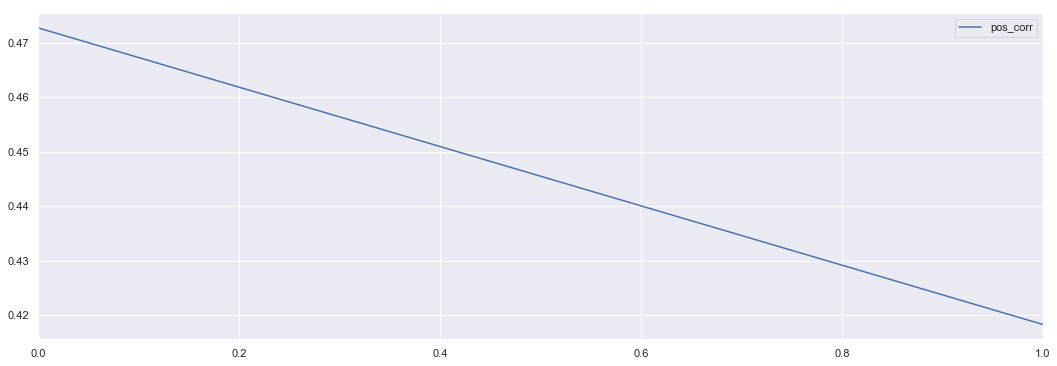

In [498]:
# Check what rolling position correlation has been changing
pos_21_rolling_corr_summary = pd.read_csv("position_21_rolling_correlation.csv")
pos_21_rolling_corr_summary.plot(figsize = (18,6))

In [499]:
# show the numbers:
pos_21_rolling_corr_summary

,date,pos_corr
0,2020-02-26,0.472670
1,2020-02-27,0.418308


In [476]:
# assuming we already have SH index data updated and inplace
# Correlation to the SH index:
sh_index = pd.read_csv(etf_path_to_csv+"sh000001.csv")

In [477]:
sh_index['pct_chg'] = sh_index['close'].pct_change()
sh_index.dropna(inplace=True)
sh_index_index_date = sh_index.copy()
sh_index_index_date.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'ts_code', 'pct_chg']
sh_index_index_date = sh_index_index_date[['date','pct_chg']]
sh_index_index_date.columns = ['date','sh_index']

In [478]:
cur_pos_merged_returns_with_sh = cur_pos_merged_returns.copy()
cur_pos_merged_returns_with_sh.reset_index(inplace = True)
cur_pos_merged_returns_with_sh['date'] = cur_pos_merged_returns_with_sh['date'].astype(str)
cur_pos_merged_returns_with_sh = cur_pos_merged_returns_with_sh.merge(sh_index_index_date, on = 'date')

In [479]:
corrs_cur_pos_with_sh_index = []
sh_index_pct_series = cur_pos_merged_returns_with_sh['sh_index']
for code in cur_positions:
    pct_series = cur_pos_merged_returns_with_sh[code]
    corr_with_sh_index = pct_series.corr(sh_index_pct_series)
    corrs_cur_pos_with_sh_index.append(corr_with_sh_index)

In [480]:
cur_pos_merged_returns_with_sh.index = pd.to_datetime(cur_pos_merged_returns_with_sh['date'])

In [481]:
cur_pos_merged_returns_with_sh.dropna(inplace = True)

In [482]:
# calculate rolling correlations
rolling_corrs_cur_pos_with_sh_index = []
sh_index_pct_series = cur_pos_merged_returns_with_sh['sh_index']
for code in cur_positions:
    pct_series = cur_pos_merged_returns_with_sh[code]
    rolling_corr_with_sh_index = pct_series.rolling(21).corr(sh_index_pct_series)
    rolling_corrs_cur_pos_with_sh_index.append(rolling_corr_with_sh_index)

In [483]:
rolling_corrs_cur_pos_sh_index_df = pd.concat(rolling_corrs_cur_pos_with_sh_index, axis=1)
rolling_corrs_cur_pos_sh_index_df.columns = cur_positions

In [500]:
rolling_corrs_cur_pos_sh_index_df

,159916,159918,159932,159933,159951,510090,510110,510270,510580,511030
date,,,,,,,,,,
2019-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-02-21,0.938014,0.601206,0.922129,0.779255,0.841141,0.704454,0.763237,0.902640,0.973574,-0.660896
2020-02-24,0.937272,0.589404,0.833130,0.781285,0.827900,0.703876,0.766212,0.901969,0.969841,-0.662356
2020-02-25,0.937503,0.594397,0.834993,0.784111,0.828516,0.707451,0.766903,0.901988,0.970039,-0.673577


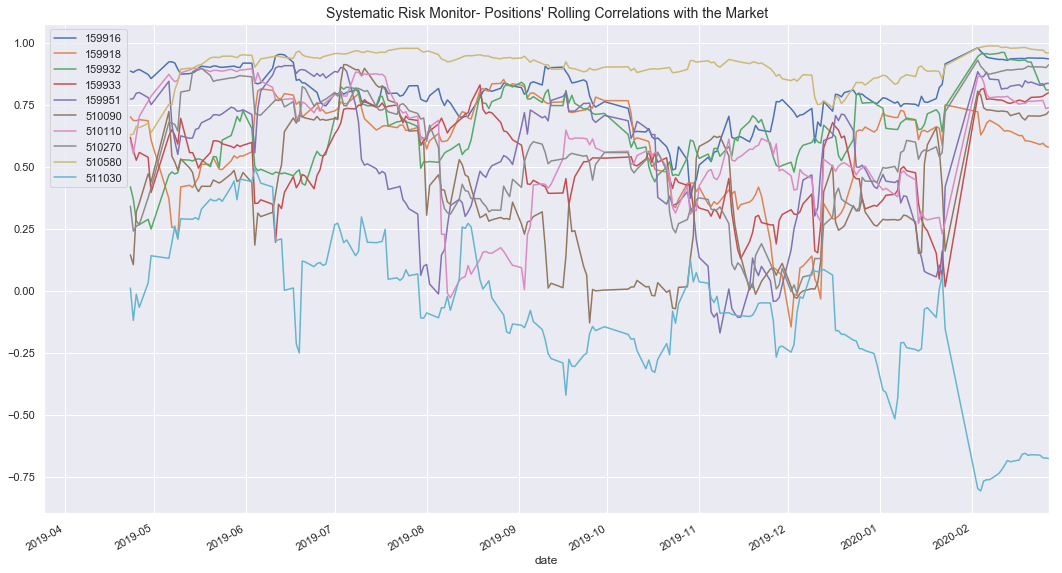

In [484]:
rolling_corrs_cur_pos_sh_index_df.plot(figsize = (18,10))
plt.title("Systematic Risk Monitor- Positions' Rolling Correlations with the Market", fontsize = 14);

In [485]:
rolling_corrs_cur_pos_sh_index_df

,159916,159918,159932,159933,159951,510090,510110,510270,510580,511030
date,,,,,,,,,,
2019-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-02-21,0.938014,0.601206,0.922129,0.779255,0.841141,0.704454,0.763237,0.902640,0.973574,-0.660896
2020-02-24,0.937272,0.589404,0.833130,0.781285,0.827900,0.703876,0.766212,0.901969,0.969841,-0.662356
2020-02-25,0.937503,0.594397,0.834993,0.784111,0.828516,0.707451,0.766903,0.901988,0.970039,-0.673577


# Performance Tracking

In [486]:
sh_index = pd.read_csv(etf_path_to_csv+"sh000001.csv")
sh_index['pct_chg'] = sh_index['close'].pct_change()
sh_index_2020 = sh_index[sh_index['trade_date']>='2020-01-02']
sh_index_2020['adjusted_pct_chg'] = sh_index_2020['pct_chg']
sh_index_2020['adjusted_pct_chg'].values[0] = 0
sh_index_2020['cum_sum_pct_chg'] = sh_index_2020['adjusted_pct_chg'].cumsum()+1

track_record = pd.DataFrame()
track_record['date'] = date
track_record['sbtv1'] = sbtv1
track_record['sh_mkt'] = sh_index_2020['cum_sum_pct_chg'].values
track_record.index = pd.to_datetime(track_record['date'])
del track_record['date']

track_record['returns0'] = track_record['sbtv1'].diff()
track_record['returns0'].values[0] = 0
track_record['returns1'] = track_record['sh_mkt'].diff()
track_record['returns1'].values[0] = 0

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [487]:
def create_sharpe_ratio(returns, periods=252):
    print("*****performance.py: 1. create_sharpe_ratio*****")
    """
    Create the Sharpe ratio for the strategy, based on a 
    benchmark of zero (i.e. no risk-free rate information).
    Parameters:
    returns - A pandas Series representing period percentage returns.
    periods - Daily (252), Hourly (252*6.5), Minutely(252*6.5*60) etc.
    """
    return np.sqrt(periods) * (np.mean(returns)) / np.std(returns)

def create_drawdowns(pnl):
    print("*****performance.py: 2. create_drawdowns*****")
    """
    Calculate the largest peak-to-trough drawdown of the PnL curve
    as well as the duration of the drawdown. Requires that the 
    pnl_returns is a pandas Series.
    Parameters:
    pnl - A pandas Series representing period percentage returns.
    Returns:
    drawdown, duration - Highest peak-to-trough drawdown and duration.
    """

    # Calculate the cumulative returns curve 
    # and set up the High Water Mark
    hwm = [0]

    # Create the drawdown and duration series
    idx = pnl.index
    drawdown = pd.Series(index = idx)
    duration = pd.Series(index = idx)

    # Loop over the index range
    for t in range(1, len(idx)):
        hwm.append(max(hwm[t-1], pnl[t]))
        drawdown[t]= (hwm[t]-pnl[t])
        duration[t]= (0 if drawdown[t] == 0 else duration[t-1]+1)
    return drawdown, drawdown.max(), duration.max()

def create_expected_annual_returns(pnl, periods=252):
    traded_days = len(pnl)
    last_pnl = pnl.values[-1]
    annual_returns = (1+last_pnl)**(periods/traded_days)-1
    return annual_returns

def create_total_returns(pnl):
    return pnl.values[-1]

In [488]:
# Calculate Alpha and Beta:

import statsmodels.api as sm
from statsmodels import regression

X = track_record['returns1'].values
Y = track_record['returns0'].values

def linreg(x, y):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y, x).fit()
    
    x = x[:,1]
    return model.params[0], model.params[1]

alpha, beta = linreg(X,Y)
print("alpha: ", str(alpha))
print("beta: ", str(beta))

alpha:  0.0003212240898729981
beta:  -0.02509858321728279


- 计算alpha，beta

https://blog.csdn.net/CoderPai/article/details/82868280 

In [489]:
sharpe_ratio0 = create_sharpe_ratio(track_record['returns0'], periods=252)
sharpe_ratio1 = create_sharpe_ratio(track_record['returns1'], periods=252)
drawdown0, max_drawdown0, max_dd_duration0 = create_drawdowns(track_record['sbtv1'])
drawdown1, max_drawdown1, max_dd_duration1 = create_drawdowns(track_record['sh_mkt'])
annual_returns0 = create_expected_annual_returns(track_record['sbtv1']-1)
annual_returns1 = create_expected_annual_returns(track_record['sh_mkt']-1)
total_returns0 = create_total_returns(track_record['sbtv1']-1)
total_returns1 = create_total_returns(track_record['sh_mkt']-1)
corr_returns0_1 = track_record['returns0'].corr(track_record['returns1'])
# jensen_alpha = total_returns0 - corr_returns0_1*total_returns1

*****performance.py: 1. create_sharpe_ratio*****
*****performance.py: 1. create_sharpe_ratio*****
*****performance.py: 2. create_drawdowns*****
*****performance.py: 2. create_drawdowns*****


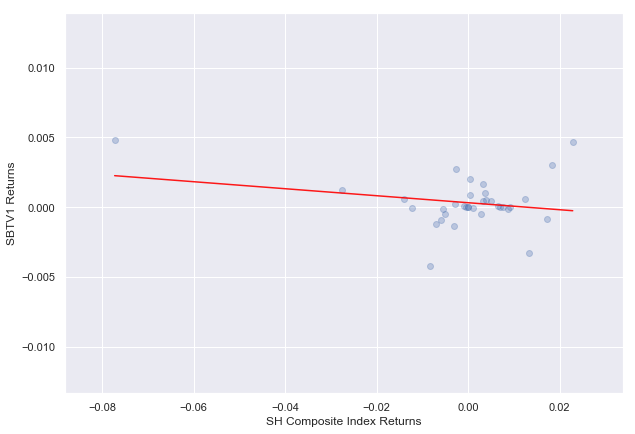

In [490]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2*beta+alpha

plt.figure(figsize=(10,7))
plt.scatter(X ,Y, alpha=0.3)
plt.xlabel("SH Composite Index Returns")
plt.ylabel("SBTV1 Returns")

plt.plot(X2, Y_hat, 'r', alpha=0.9)
plt.show()

In [491]:
last_day = sh_index['trade_date'].values[-1]

print("=========================SBTV1策略=======================")
print("\n")
print("SBTV1策略 - 开始时间：2020-01-02")
print("SBTV1策略 - 当前时间：{}".format(last_day))
print("SBTV1策略 - 实时 绝对收益：", round(total_returns0*100, 2), "%")
print("SBTV1策略 - 实时 夏普比率：", round(sharpe_ratio0, 2))
print("SBTV1策略 - 实时 期望年化收益率：", round(annual_returns0*100, 2),"%")
print("SBTV1策略 - 实时 最大回撤比率：", round(max_drawdown0*100,2), "%")
print("SBTV1策略 - 实时 最大回撤持续时间：", int(max_dd_duration0), "天")
print("SBTV1策略 - 实时 Beta：", round(beta, 4))
print("SBTV1策略 - 实时 超额收益Alpha：", round(total_returns0-total_returns1, 4))
print("SBTV1策略 - 实时 风险调整Alpha：", round(alpha, 6))
print("\n")
print("=========================上证指数=======================")
print("\n")
print("上证指数 - 开始时间：2020-01-02")
print("上证指数 - 当前时间：{}".format(last_day))
print("上证指数 - 实时 绝对收益：", round(total_returns1*100,2), "%")
print("上证指数 - 实时 夏普比率：", round(sharpe_ratio1, 2))
print("上证指数 - 实时 最大回撤比率：", round(max_drawdown1*100,2), "%")
print("上证指数 - 实时 最大回撤持续时间：", int(max_dd_duration1), "天")

=========================SBTV1策略=======================


SBTV1策略 - 开始时间：2020-01-02
SBTV1策略 - 当前时间：2020-02-27
SBTV1策略 - 实时 绝对收益： 1.19 %
SBTV1策略 - 实时 夏普比率： 3.16
SBTV1策略 - 实时 期望年化收益率： 8.89 %
SBTV1策略 - 实时 最大回撤比率： 0.52 %
SBTV1策略 - 实时 最大回撤持续时间： 9 天
SBTV1策略 - 实时 Beta： -0.0251
SBTV1策略 - 实时 超额收益Alpha： 0.038
SBTV1策略 - 实时 风险调整Alpha： 0.000321


=========================上证指数=======================


上证指数 - 开始时间：2020-01-02
上证指数 - 当前时间：2020-02-27
上证指数 - 实时 绝对收益： -2.61 %
上证指数 - 实时 夏普比率： -0.73
上证指数 - 实时 最大回撤比率： 12.24 %
上证指数 - 实时 最大回撤持续时间： 27 天


In [492]:
my_strat_plot = go.Scatter(
    x = track_record.index,
    y = track_record['sbtv1'],
    name = 'SBTV1策略累计收益率'
)
 
    
mkt_plot = go.Scatter(
    x = track_record.index,
    y = track_record['sh_mkt'],
    name = '上证指数累积收益率'
)
    
layout = dict(title = 'SBTV1策略累计收益率',
              xaxis = dict(title = '时间'), # 横轴坐标
              yaxis = dict(title = '收益率'), # 总轴坐标
              legend=dict(x=1.1,y=1) # 图例位置 
              )

data = [my_strat_plot, mkt_plot]

fig = dict(data=data, layout=layout)

py.iplot(fig)

# Check Details of Filtered ETFs

In [493]:
og_etf_file = pd.read_csv(etf_ticker_path)
corr_mean_df_assets['etf'] = corr_mean_df_assets['etf']+".OF"
og_etf_file.columns = ['etf', '证券简称', '投资类型(一级分类)', '投资类型(二级分类)', '基金规模\n[单位] 元',
       '机构投资者持有份额\n[报告期] 2019中报\n[单位] 份', '机构投资者持有比例\n[报告期] 2019中报\n[单位] %',
       '管理费率\n[单位] %', '托管费率\n[单位] %', '认购费率\n[收费类型] 前端']
corr_mean_df_assets_info = corr_mean_df_assets.merge(og_etf_file, on = 'etf')

In [494]:
corr_mean_df_assets_info.to_csv("filtered_50_etfs_by_vol_20200224.csv")

# Calculate Market Slippage and Impact

In [495]:
vol_filtered_df

,date,open,close,high,low,volume,code,252_vol_ewm,vol_ewm_rank
16321,2020-02-27,1.059,1.055,1.077,1.046,19641123.0,512880,8.542141e+06,1.0
18108,2020-02-27,1.195,1.201,1.202,1.189,20085145.0,510900,8.492238e+06,2.0
27682,2020-02-27,0.820,0.814,0.832,0.801,18214653.0,159949,6.928194e+06,3.0
4155,2020-02-27,2.894,2.898,2.914,2.892,3810776.0,510050,5.904491e+06,4.0
14082,2020-02-27,2.111,2.111,2.148,2.076,7620196.0,159915,5.042434e+06,5.0
26807,2020-02-27,1.472,1.474,1.476,1.464,8073938.0,159920,4.951788e+06,6.0
33957,2020-02-27,1.008,1.003,1.025,0.999,9206760.0,512000,3.862145e+06,7.0
6042,2020-02-27,4.083,4.071,4.097,4.061,4753305.0,510300,3.587162e+06,8.0
19712,2020-02-27,3.665,3.669,3.690,3.665,6056712.0,518880,3.567235e+06,9.0
1689,2020-02-27,6.225,6.215,6.297,6.166,2554707.0,510500,2.273851e+06,10.0
